# 1. Importing Library

Mengimport beberapa library yang akan dibutuhkan

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

# 2. Data Loading

Mengunduh dataset octopustema/full-imdb-dataset dari kaggle menggunakn Kaggle API.

In [2]:
!kaggle datasets download -d octopusteam/full-imdb-dataset

Dataset URL: https://www.kaggle.com/datasets/octopusteam/full-imdb-dataset
License(s): CC0-1.0
 45% 9.00M/19.9M [00:00<00:00, 92.3MB/s]
100% 19.9M/19.9M [00:00<00:00, 147MB/s] 


Selanjutnya, mengekstrak file ZIP yang diunduh ke folder bernama fullimdb-dataset

In [3]:
!unzip full-imdb-dataset -d full-imdb-dataset

Archive:  full-imdb-dataset.zip
  inflating: full-imdb-dataset/data.csv  


In [4]:
df = pd.read_csv("full-imdb-dataset/data.csv")
df

,id,title,type,genres,averageRating,numVotes,releaseYear
0,tt0000009,Miss Jerry,movie,Romance,5.4,218.0,1894.0
1,tt0000147,The Corbett-Fitzsimmons Fight,movie,"Documentary, News, Sport",5.2,547.0,1897.0
2,tt0000502,Bohemios,movie,NaN,4.4,18.0,1905.0
3,tt0000574,The Story of the Kelly Gang,movie,"Action, Adventure, Biography",6.0,958.0,1906.0
4,tt0000591,The Prodigal Son,movie,Drama,5.6,30.0,1907.0
...,...,...,...,...,...,...,...
1037895,tt35279962,Rooted (Feature),movie,Horror,NaN,NaN,NaN
1037896,tt35279971,The Return of the Sister-in-Law,movie,"Action, Crime, Drama",NaN,NaN,2021.0
1037897,tt35279979,Desert Monster,movie,"Action, Fantasy",NaN,NaN,2022.0
1037898,tt35280218,Don't Take Your Guns to Mexico,movie,Western,NaN,NaN,NaN


dari data diatas terlihat 7 variabel dengan jumlah sebanyak 1037553

# 3. Data Understanding

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1037900 entries, 0 to 1037899
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   id             1037900 non-null  object 
 1   title          1037898 non-null  object 
 2   type           1037900 non-null  object 
 3   genres         936660 non-null   object 
 4   averageRating  444069 non-null   float64
 5   numVotes       444069 non-null   float64
 6   releaseYear    908004 non-null   float64
dtypes: float64(3), object(4)
memory usage: 55.4+ MB


dari hasil diatas, dapat dilihat bahwa:

kolom bertipe object: id, title, type, genres.

kolom bertipe float64: averageRating, numVotes, releaseYear.


kode dibawah ini untuk melihat berapa banyak entri yang unik berdasarkan title dan genres

In [6]:
print('Banyak IMDB: ', len(df.title.unique()))
print('Genre IMDB: ', df.genres.unique())

Banyak IMDB:  884503
Genre IMDB:  ['Romance' 'Documentary, News, Sport' nan ... 'Action, History, Sport'
 'Biography, Fantasy, Music' 'Horror, Mystery, News']


Selanjutnya, memeriksa nilai 0 pada setiap kolom

In [7]:
df.isnull().sum()

,0
id,0
title,2
type,0
genres,101240
averageRating,593831
numVotes,593831
releaseYear,129896


Terdapat banyak missing value pada beberapa kolom seperti genres, averageRating, numVotes, releaseYear. untuk kolom title ada sedikit missing value.

kode dibawah untuk mengecek apakah ada duplikat

In [9]:
df.duplicated().sum()

0

hasil dari kode diatas adalah 0 yang merarti tidak ada data duplikat dalam dataset ini.

Selanjutnya, Memeriksa Outlier pada kolom Numerik

<Axes: xlabel='numVotes'>

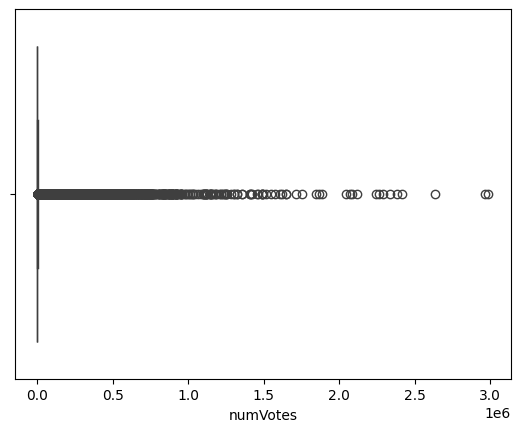

In [10]:
sns.boxplot(x = df["numVotes"])

ada banyak outlier pada kolom numVotes

<Axes: xlabel='averageRating'>

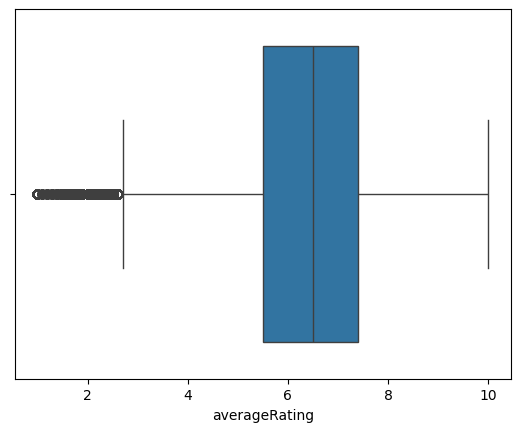

In [11]:
sns.boxplot(x = df["averageRating"])

Bisa dilihat dari visualisasi diatas, terdapat outlier pada kolom averageRating

<Axes: xlabel='releaseYear'>

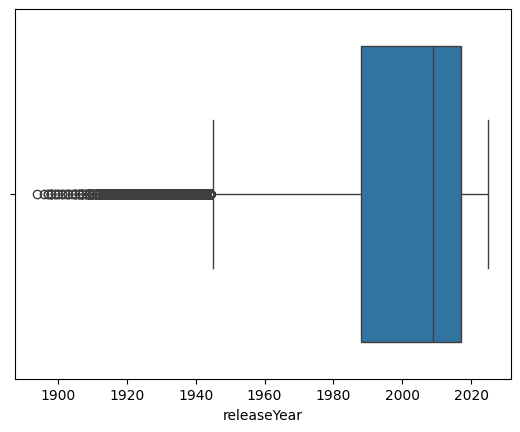

In [12]:
sns.boxplot(x = df["releaseYear"])

pada kolom releaseYear juga ada outlier

# 4. Data Preparation dan univariate analysis

kode dibawah ini untuk membersihkan missing value dengan fungsi dropna()

In [8]:
df = df.dropna()
df.isnull().sum()

,0
id,0
title,0
type,0
genres,0
averageRating,0
numVotes,0
releaseYear,0


data sudah bersih dari missing value

Terlihat bahwa terdapat outlier pada semua kolom numerik. dalam kasus ini, kita akan menghapus outlier menggunakan teknik **Interquartile Range (IQR)**. IQR dihitung sebagai:

IQR=Q3−Q1

dengan:

Batas Bawah:
Q1−1.5*IQR

Batas Atas:
Q3+1.5*IQR

Outlier adalah nilai yang berada di luar batas ini, dan akan dihapus dari dataset.


In [13]:
numeric_columns = df.select_dtypes(include = ["number"]).columns

Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

df = df[~((df[numeric_columns] < (Q1 - 1.5 * IQR)) |
         (df[numeric_columns] > (Q3 + 1.5 * IQR))).any(axis =1)]

df.shape

(338158, 7)

setelah outlier dihapus dengan teknik IQR, data menyisahkan 338158 baris dan 7 kolom

In [14]:
def reduce_memory(data):
    for col in data.columns:
        if data[col].dtype == 'float64':
            data[col] = data[col].astype('float32')
        elif data[col].dtype == 'int64':
            data[col] = data[col].astype('int32')
    return data

kode diatas untuk bertujuan untuk mengurangi penggunaan memori pada dataframe. tipe data float64 diubah menjadi float32. dengan perubahan ini, ukuran memori yang digunakan menjadi lebih kecil. sementara isi data tetap sama.

In [35]:
df = reduce_memory(df)

df diproses dengan fungsi reduce_memory yang sebelumnya dijelaskan, sehingga tipe data kolom-kolomnya diubah untuk mengurangi penggunaan memori.

In [16]:
df = df.sample(frac=0.05, random_state=42)

df diambil sampel acak sebesar 5% dari total data (ditentukan oleh frac=0.05). Argumen random_state=42 memastikan pengambilan sampel acak ini konsisten setiap kali kode dijalankan.

In [17]:
df.shape

(16908, 7)

terlihat ukuran df memiliki 16908 baris dan 7 kolom

In [18]:
print(df['genres'].value_counts())

genres
Drama                           2950
Documentary                     2158
Comedy                          1711
Drama, Romance                   469
Comedy, Drama                    433
                                ... 
Musical, Mystery, Romance          1
Sci-Fi, Western                    1
Biography, Documentary, War        1
Action, Crime, Fantasy             1
Documentary, Mystery, Sci-Fi       1
Name: count, Length: 729, dtype: int64


Kolom genres menunjukkan kategori atau kombinasi genre dari data.

Genre yang paling umum adalah Drama (2950 film).

Kombinasi genre seperti "Drama, Romance" dan "Comedy, Drama" juga cukup banyak.

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16908 entries, 288769 to 867533
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             16908 non-null  object 
 1   title          16908 non-null  object 
 2   type           16908 non-null  object 
 3   genres         16908 non-null  object 
 4   averageRating  16908 non-null  float32
 5   numVotes       16908 non-null  float32
 6   releaseYear    16908 non-null  float32
dtypes: float32(3), object(4)
memory usage: 858.6+ KB


hasil diatas informasi struktur dataframe yang memiliki 7 kolom, dengan 3 kolom float32 dan 4 kolom bertipe object. dan ukuran memori setelah pengolahan adalah 858.6+ KB, lebih kecil dari sebelumnya yang berukuran 55.4+ MB

In [20]:
df.describe()

,averageRating,numVotes,releaseYear
count,16908.000000,16908.000000,16908.000000
mean,6.440827,98.061867,2002.525146
std,1.385983,136.401932,19.818035
min,2.700000,5.000000,1945.000000
25%,5.500000,15.000000,1991.000000
50%,6.500000,37.000000,2010.000000
75%,7.400000,118.000000,2018.000000
max,10.000000,670.000000,2025.000000


averageRating:

Rata-rata rating film adalah 6.44, dengan nilai minimum 2.7 dan maksimum 10.

numVotes:

Jumlah suara rata-rata adalah 98, dengan minimum 5 suara dan maksimum hampir 670 suara.

releaseYear:

Rata-rata tahun rilis adalah 2002.53, dengan rentang dari 1945 hingga 2025.

In [21]:
numerical_cols = df.select_dtypes(include=['float32']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

kode diatas:
memilih kolom dengan tipe data float32 dan hasilny adalah daftar nama kolom numerik.

memilih kolom dengan tipe data object dan hasilnya adalah daftar nama kolom kategorikal.

kode dibawah ini pada Loop pertama memplot histogram untuk setiap kolom numerik (float32) di DataFrame.

Menggunakan sns.histplot untuk membuat histogram dengan distribusi kernel density estimation (KDE).

Setiap histogram menunjukkan distribusi nilai (misalnya, rating, jumlah suara, tahun rilis).

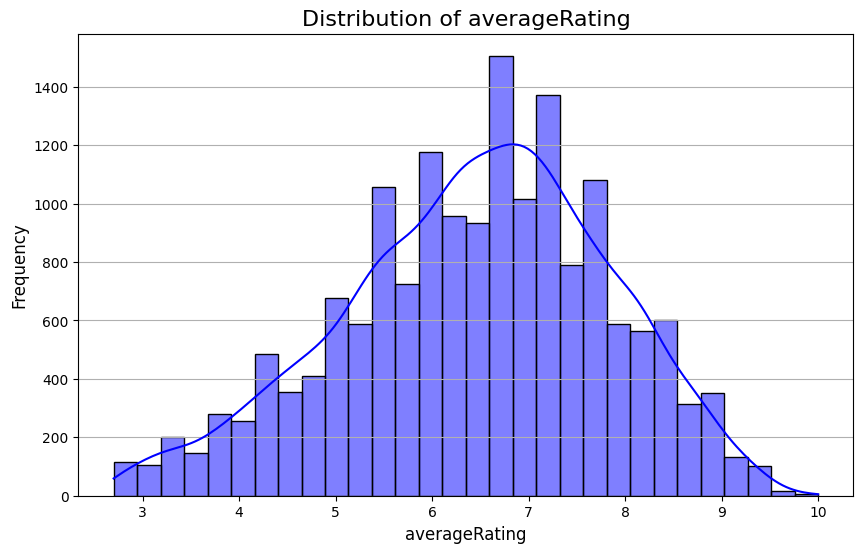

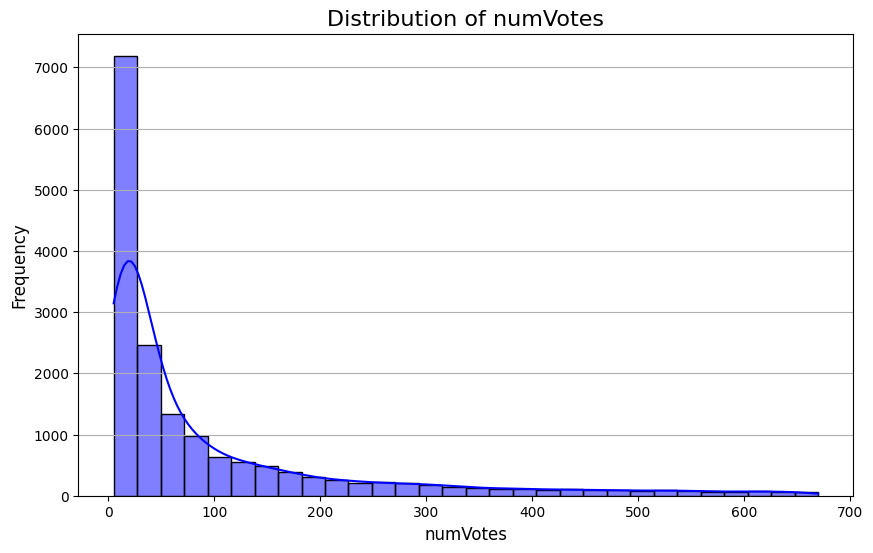

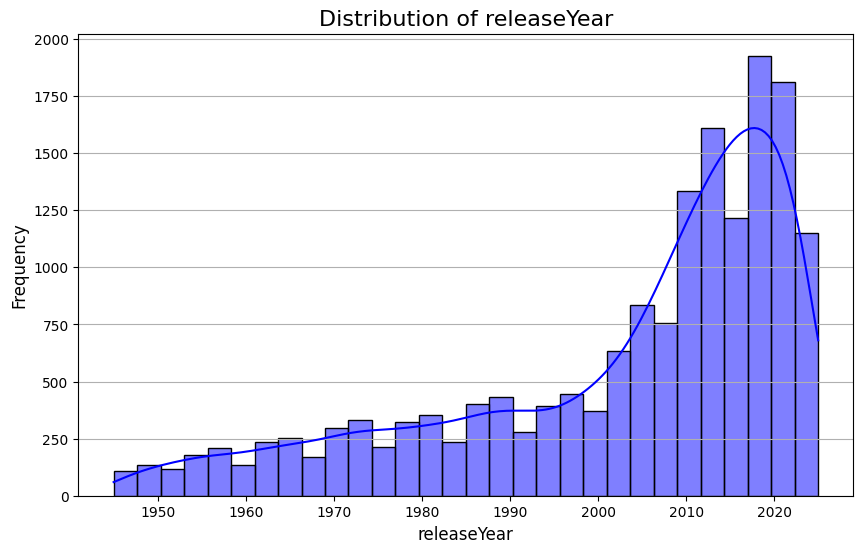

In [22]:
for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {col}", fontsize=16)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.grid(axis='y')
    plt.show()

Hasil:

Grafik distribusi untuk:

averageRating — biasanya berbentuk lonceng, menunjukkan persebaran rating film.

numVotes — sering kali miring ke kanan (positively skewed), karena ada banyak film dengan suara rendah dan beberapa dengan suara sangat tinggi.

releaseYear — bisa menunjukkan pola historis dalam data (misalnya, lebih banyak film rilis setelah tahun tertentu).

kode di bawah pada Loop kedua memplot bar chart untuk 10 kategori teratas dalam setiap kolom kategorikal (object).

Menggunakan value_counts().head(10) untuk mendapatkan frekuensi 10 nilai paling umum.

sns.barplot memvisualisasikan jumlah setiap kategori.

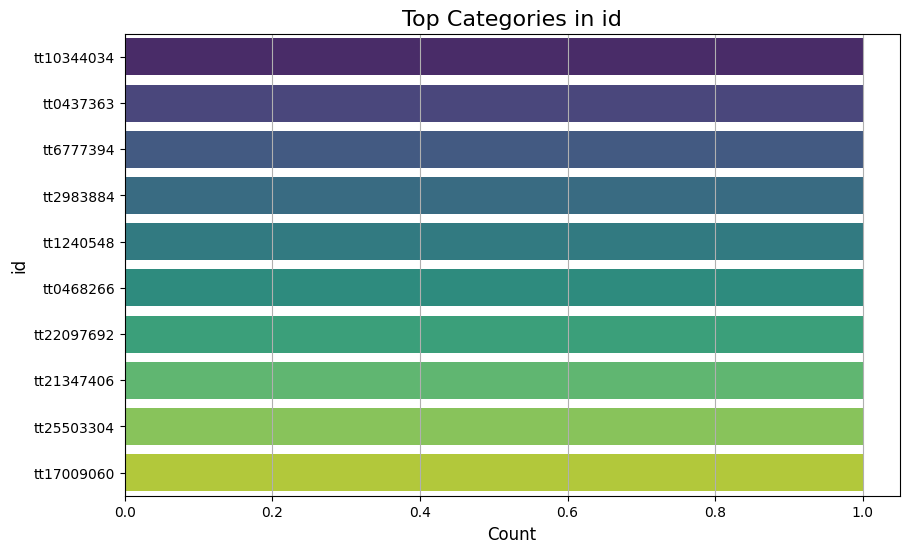

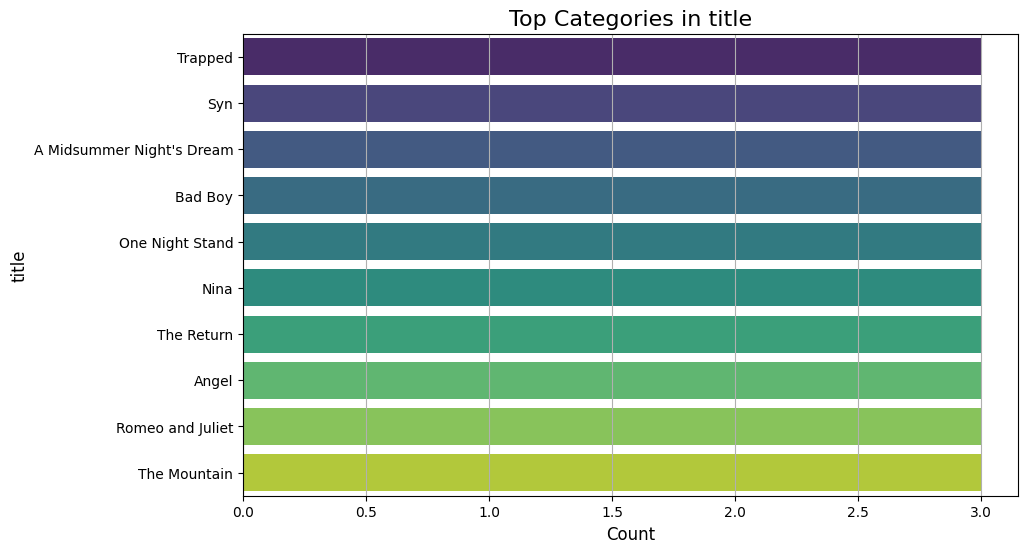

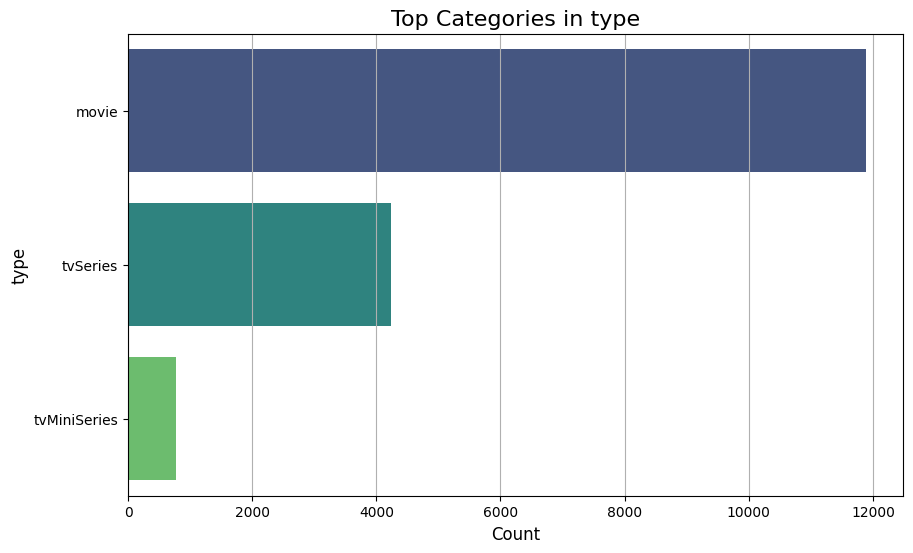

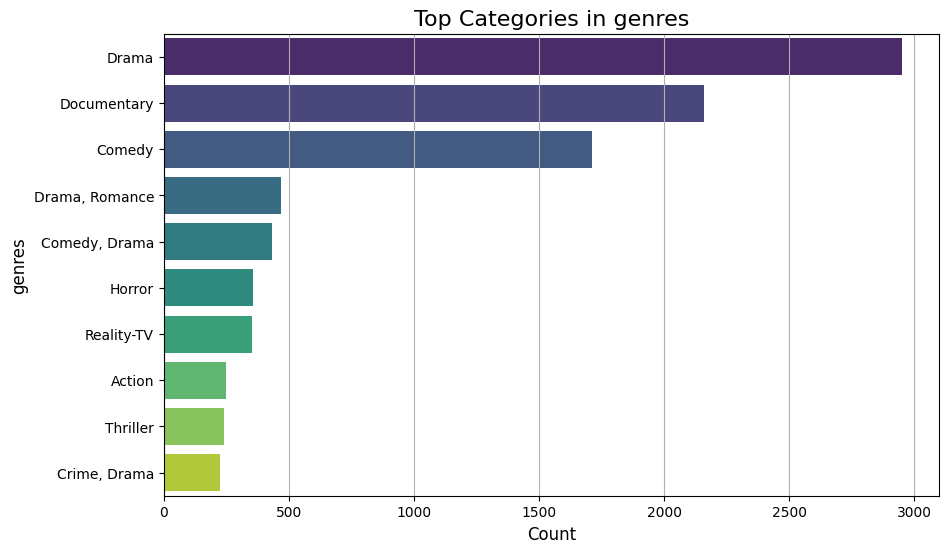

In [23]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    value_counts = df[col].value_counts().head(10)
    sns.barplot(x=value_counts.values, y=value_counts.index, hue=value_counts.index, dodge=False, palette="viridis", legend=False)
    plt.title(f"Top Categories in {col}", fontsize=16)
    plt.xlabel("Count", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='x')
    plt.show()

Hasil:

Grafik bar horizontal untuk setiap kolom kategorikal, seperti:

genres — menunjukkan genre yang paling sering muncul.

type — jika ada, biasanya menunjukkan kategori seperti film, serial, atau dokumenter.

title atau id — mungkin tidak terlalu informatif jika nilai sangat unik.

# 5. Content Based Filtering

In [24]:
tf = TfidfVectorizer()
tf.fit(df['genres'])
tf.get_feature_names_out()

array(['action', 'adult', 'adventure', 'animation', 'biography', 'comedy',
       'crime', 'documentary', 'drama', 'family', 'fantasy', 'fi', 'film',
       'game', 'history', 'horror', 'music', 'musical', 'mystery', 'news',
       'noir', 'reality', 'romance', 'sci', 'short', 'show', 'sport',
       'talk', 'thriller', 'tv', 'war', 'western'], dtype=object)

kode diatas ini menggunakan tfidVectorizer untuk memproses teks pada kolom genres dan mengubahnya menjadi representasi vektor berdasarkan bobot TF-IDF. Prosesnya dimulai dengan melatih model TF-IDF pada data genres, sehingga model mengenali semua kata unik yang ada. Kemudian, dengan tf.get_feature_names_out(), dihasilkan daftar kata-kata unik yang ditemukan, seperti action, comedy, drama, hingga subkategori seperti sci, fi, dan talk. Hasil ini berguna untuk analisis teks lebih lanjut, seperti menghitung kemiripan genre atau membuat model prediksi berdasarkan genre.

In [25]:
tfidf_matrix = tf.fit_transform(df['genres'])
tfidf_matrix.shape

(16908, 32)

Kode diatas menghasilkan matriks TF-IDF dengan ukuran (16908, 32).

In [26]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.]])

Kode di atas mengubah matriks TF-IDF yang awalnya berbentuk sparse (berisi banyak nilai nol) menjadi bentuk dense (matriks penuh).

Hasilnya adalah sebuah matriks dua dimensi di mana:

- Setiap baris mewakili satu film.
- Setiap kolom mewakili kata atau fitur yang terdapat dalam genre film.

Nilai-nilai dalam matriks menunjukkan skor TF-IDF untuk setiap kata di setiap film. Sebagian besar nilainya tetap nol, menunjukkan bahwa kata tersebut tidak relevan untuk genre film tertentu.

Sebagai contoh, pada matriks ini, terdapat nilai 1.0 pada baris terakhir di kolom tertentu. Ini menunjukkan bahwa kata tertentu memiliki bobot TF-IDF penuh dalam genre film terakhir, sementara kolom lainnya memiliki nilai 0, yang berarti kata-kata tersebut tidak muncul di genre film tersebut.

In [27]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tf.get_feature_names_out(),
    index=df.title
).sample(22, axis=1).sample(10, axis=0)

,family,adventure,talk,reality,sport,war,show,horror,thriller,biography,...,western,noir,musical,short,music,fantasy,news,documentary,drama,action
title,,,,,,,,,,,,,,,,,,,,,
Perversión en el paraíso,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
True Fear: The Making of Psycho,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000
Anatomy of a Springroll,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,0.000000
Indian Warrior Ghost,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Love... and Other Reasons to Panic,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.741094,0.0,0.0,0.0,0.000000,0.000000
Sir Last Chance,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Next Time Ned,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.622399,0.000000
Peacemaker Kurogane: Omo-michi,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.583637
The Singles Table,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


kode diatas adalah sebuah DataFrame yang berisi representasi TF-IDF untuk genre-genre film di kolom genres, dengan baris yang menunjukkan judul film dan kolom yang menunjukkan kata-kata genre yang ditemukan dalam dataset.

Di dalamnya terdapat 10 baris yang mewakili 10 judul film, dan 22 kolom yang mewakili 22 kata unik atau genre (misalnya, family, adventure, talk, dll.).
Nilai dalam matriks menunjukkan seberapa penting sebuah genre (kolom) untuk setiap film (baris) berdasarkan perhitungan TF-IDF. Nilai 0 berarti genre tersebut tidak muncul dalam film tersebut, sementara nilai yang lebih tinggi menunjukkan genre tersebut memiliki kontribusi yang lebih besar terhadap film tersebut.

Misalnya, Pada film "Hogan," nilai 0.785408 di kolom sport menunjukkan bahwa genre "sport" sangat relevan untuk film tersebut. Sementara di film "Peacemaker Kurogane: Omo-michi," terdapat nilai 0.583637 di kolom action, menandakan bahwa genre "action" adalah salah satu aspek penting dari film tersebut.

Dengan cara ini, kita bisa melihat seberapa relevan setiap genre terhadap film tertentu berdasarkan perhitungan TF-IDF.

In [28]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

kode diatas menggunakan cosine_similarity untuk menghitung kemiripan antar film berdasarkan representasi TF-IDF yang dihasilkan sebelumnya

asilnya adalah matriks cosine similarity yang menunjukkan seberapa mirip setiap pasangan film. Nilai 1.0 menunjukkan bahwa dua film sangat mirip (misalnya, film yang sama), sementara nilai mendekati 0 berarti film tersebut sangat berbeda.

In [29]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['title'], columns=df['title'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (16908, 16908)


title,Honey Baby,When the City Awakes,Midnight Frights,Secrets of the Sun with Dara O Briain,Janwar Aur Insaan
title,,,,,
Polovodye,0.491422,0.359352,0.413166,0.0,1.000000
Nazi Undead,0.150236,0.109860,0.126312,0.0,0.305717
De Perto Ela Não é Normal,0.000000,0.000000,0.519579,0.0,0.000000
Rama Chakkani Seetha,1.000000,0.176594,0.203039,0.0,0.491422
Republic of Twitter,0.491422,0.359352,0.413166,0.0,1.000000
Quarantine Relationship,0.491422,0.359352,0.413166,0.0,1.000000
Irwin Hearts Mandy,0.000000,0.000000,0.189180,0.0,0.000000
Pravda,0.152134,0.111248,0.127908,0.0,0.309579
Stolen Art,0.000000,0.000000,0.000000,1.0,0.000000


Kode di atas mengubah matriks cosine similarity yang sebelumnya dihitung menjadi sebuah DataFrame dengan baris dan kolom yang mewakili judul film. Dimensi DataFrame ini adalah (16908, 16908), yang menunjukkan bahwa ada 16,908 film, dan setiap film dibandingkan dengan film lainnya untuk menghitung tingkat kemiripan berdasarkan genre mereka.

Hasil dari cosine_sim_df.sample(5, axis=1).sample(10, axis=0) menampilkan sampel acak dari matriks tersebut. Setiap nilai dalam matriks ini menunjukkan tingkat kemiripan antar film. Sebagai contoh, untuk film "Polovodye", kemiripan dengan film lainnya, seperti "Rama Chakkani Seetha", mencapai 1.0, yang berarti kedua film tersebut sangat mirip, sementara film lainnya memiliki nilai lebih rendah, menunjukkan tingkat kemiripan yang lebih rendah.

In [30]:
def df_recommendations(judul_df, similarity_data=cosine_sim_df, items=df[['title', 'genres']], k=5):

    index = similarity_data.loc[:,judul_df].to_numpy().argpartition(
        range(-1, -k, -1))

    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    closest = closest.drop(judul_df, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

kode diatas:

Fungsi df_recommendations digunakan untuk memberikan rekomendasi film berdasarkan kemiripan genre, yang dihitung sebelumnya menggunakan cosine similarity. Fungsi ini menerima beberapa parameter, seperti judul film yang ingin diberikan rekomendasi (misalnya, judul_df), data kemiripan (default-nya cosine_sim_df), dan daftar film yang berisi judul dan genre (default-nya adalah kolom title dan genres dari DataFrame df).

Prosesnya dimulai dengan mencari indeks film-film yang paling mirip dengan judul_df dalam matriks kemiripan, lalu memilih k film teratas yang memiliki nilai kemiripan tertinggi. Film yang sama dengan judul_df akan dihapus dari hasil rekomendasi, dan hasilnya akan ditampilkan bersama dengan informasi judul dan genre.

In [31]:
df[df.title.eq('AstroLOLogy')]

,id,title,type,genres,averageRating,numVotes,releaseYear
277121,tt10044790,AstroLOLogy,tvMiniSeries,"Adventure, Animation, Comedy",9.1,15.0,2017.0


hasilnya adalah informasi tentang film berjudul "AstroLOLogy", yang merupakan film dengan genre Adventure, Animation, Comedy, memiliki rating rata-rata 9.1, dan dirilis pada tahun 2017.

In [34]:
result = df_recommendations('AstroLOLogy')
result

,title,genres
0,Norm of the North: Family Vacation,"Adventure, Animation, Comedy"
1,ToonMarty,"Adventure, Animation, Comedy"
2,Tom and Jerry in New York,"Adventure, Animation, Comedy"
3,Work It Out Wombats!,"Adventure, Animation, Comedy"
4,Thomas & Friends: Sodor's Legend of the Lost T...,"Adventure, Animation, Comedy"


berdasarkan kemiripan genre dengan film "AstroLOLogy". Semua film yang direkomendasikan memiliki genre yang sama, yaitu Adventure, Animation, Comedy, dan film-film tersebut adalah:

Norm of the North: Family Vacation, ToonMarty, Tom and Jerry in New York, Work it Out Wombats!, Thomas & Friends: Sodor's Legend of the Lost Treasure

In [33]:
a = 0

for row in result.itertuples():
  if (row.genres == 'Adventure', 'Animation', 'Comedy'):
    a += 1

precision = (a/5)*100
print("The precision of the model is {}%".format(precision))

The precision of the model is 100.0%


Hasil yang dicetak, yaitu 100.0%, menunjukkan bahwa seluruh film dalam hasil rekomendasi memiliki genre yang termasuk dalam daftar yang diperiksa, sehingga presisi model adalah 100%.

Namun, jika genre film yang direkomendasikan tidak memenuhi kriteria tersebut, maka presisi akan lebih rendah.